# The NYC Tree project working title: Will a Tree Fall on Me?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

First, let's open the street tree data, tree warning data, and tree fall for EDA

In [2]:
# Import tree survey data
data = geopandas.read_file('Data/Trees/2015 Street Tree Census - Tree Data/geo_export_f9cac9c3-66c4-45b6-899b-823a270d8754.shp')

In [49]:
# Turn tree survey data into a normal dataframe and remove a bunch of columns
data_nogeom = pd.DataFrame(data.drop(columns='geometry'), copy=True)
data_nogeom=data_nogeom.drop(['block_id', 'boro_ct', 'borocode', 'boroname', 'brnch_ligh',
       'brnch_othe', 'brnch_shoe', 'cb_num', 'cncldist','nta',
       'nta_name','spc_latin', 'st_assem', 'st_senate', 'state','stump_diam','user_type', 'x_sp', 'y_sp', 'zip_city'],axis=1)

In [50]:
data_nogeom.columns

Index(['address', 'created_at', 'curb_loc', 'guards', 'health', 'latitude',
       'longitude', 'problems', 'root_grate', 'root_other', 'root_stone',
       'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh', 'tree_id',
       'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode'],
      dtype='object')

In [51]:
# Import fall data
data_falls = pd.read_csv('Data/311/Tree_Fall_311.csv',quoting=3)
data_falls = data_falls.drop(['Incident Zip',
       'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Status', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)'],axis=1)

In [52]:
data_falls.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type',
       'Descriptor', 'Location Type', 'Incident Address', 'Latitude',
       'Longitude'],
      dtype='object')

In [53]:
# Remove the falls before 2015 (before survey)
data_falls['Created Date']= pd.to_datetime(data_falls['Created Date'])
data_falls = data_falls.where(data_falls['Created Date']>'2015-01-01')

In [54]:
# Merge falls and tree survey based on address
data_with_falls = data_falls.merge(data_nogeom,how="right",left_on="Incident Address",right_on="address")

In [55]:
# Create column Fall to have True/False for if tree branch or full tree fell
data_with_falls['Fall']=  list(map(lambda x: not np.isnan(x),data_with_falls['Unique Key']))
data_with_falls['Fall'].head()

0    True
1    True
2    True
3    True
4    True
Name: Fall, dtype: bool

In [56]:
# How many trees fell?
data_with_falls.groupby('Fall').count().zipcode

Fall
False    655286
True      41327
Name: zipcode, dtype: int64

In [57]:
# Import reported damages data
data_damage = pd.read_csv('Data/311/Tree_Damage_311.csv')
data_damage = data_damage.drop(['Incident Zip',
       'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Status', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)'],axis=1)

In [58]:
data_with_falls.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type',
       'Descriptor', 'Location Type', 'Incident Address', 'Latitude',
       'Longitude', 'address', 'created_at', 'curb_loc', 'guards', 'health',
       'latitude', 'longitude', 'problems', 'root_grate', 'root_other',
       'root_stone', 'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh',
       'tree_id', 'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode', 'Fall'],
      dtype='object')

In [61]:
# Merge in tree warning data
data_with_falls_damage = data_damage.merge(data_with_falls,how="right",left_on="Incident Address",right_on="address")

In [74]:
# Create column Damage to have True/False for if any damage was reported
data_with_falls_damage['Damage']=  list(map(lambda x: not np.isnan(x),data_with_falls_damage['Unique Key_x']))


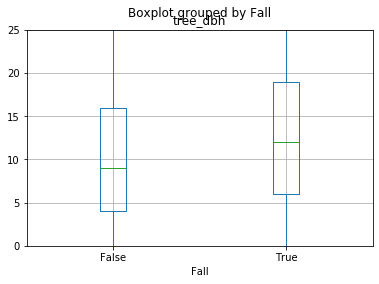

In [63]:
# Boxplot of diameters for trees that have or have not fallen
ax = data_with_falls.boxplot(column='tree_dbh',by='Fall')
ax.set_ylim(0, 25)

plt.show()

In [64]:
# Check if the difference is significant (Mann-Whitney U Test)
sp.stats.mannwhitneyu(data_with_falls.tree_dbh.where(data_with_falls['Fall']==True).dropna(),data_with_falls.tree_dbh.where(data_with_falls['Fall']==False).dropna())


MannwhitneyuResult(statistic=11392743097.0, pvalue=0.0)

In [65]:
# Now check health
dftemp=pd.DataFrame()
dftemp['Poor']=data_with_falls[data_with_falls['health']=='Poor'].groupby('Fall').count().zipcode
dftemp['Fair']=data_with_falls[data_with_falls['health']=='Fair'].groupby('Fall').count().zipcode
dftemp['Good']=data_with_falls[data_with_falls['health']=='Good'].groupby('Fall').count().zipcode


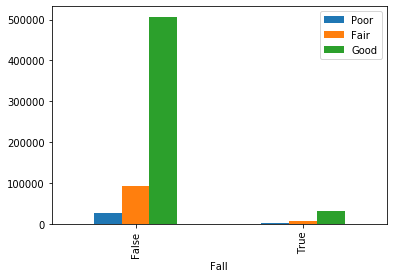

In [66]:
dftemp.plot.bar()

In [67]:
sp.stats.chi2_contingency(dftemp)

(34.123276874637256,
 3.892463729494788e-08,
 2,
 array([[ 25761.66460207,  92391.10336181, 506839.23203612],
        [  1623.33539793,   5821.89663819,  31937.76796388]]))

In [68]:
# Now check species
dftemp=pd.DataFrame()
for tree in data_with_falls['spc_common'].unique():
    dftemp[tree]=data_with_falls[data_with_falls['spc_common']==tree].groupby('Fall').count().zipcode


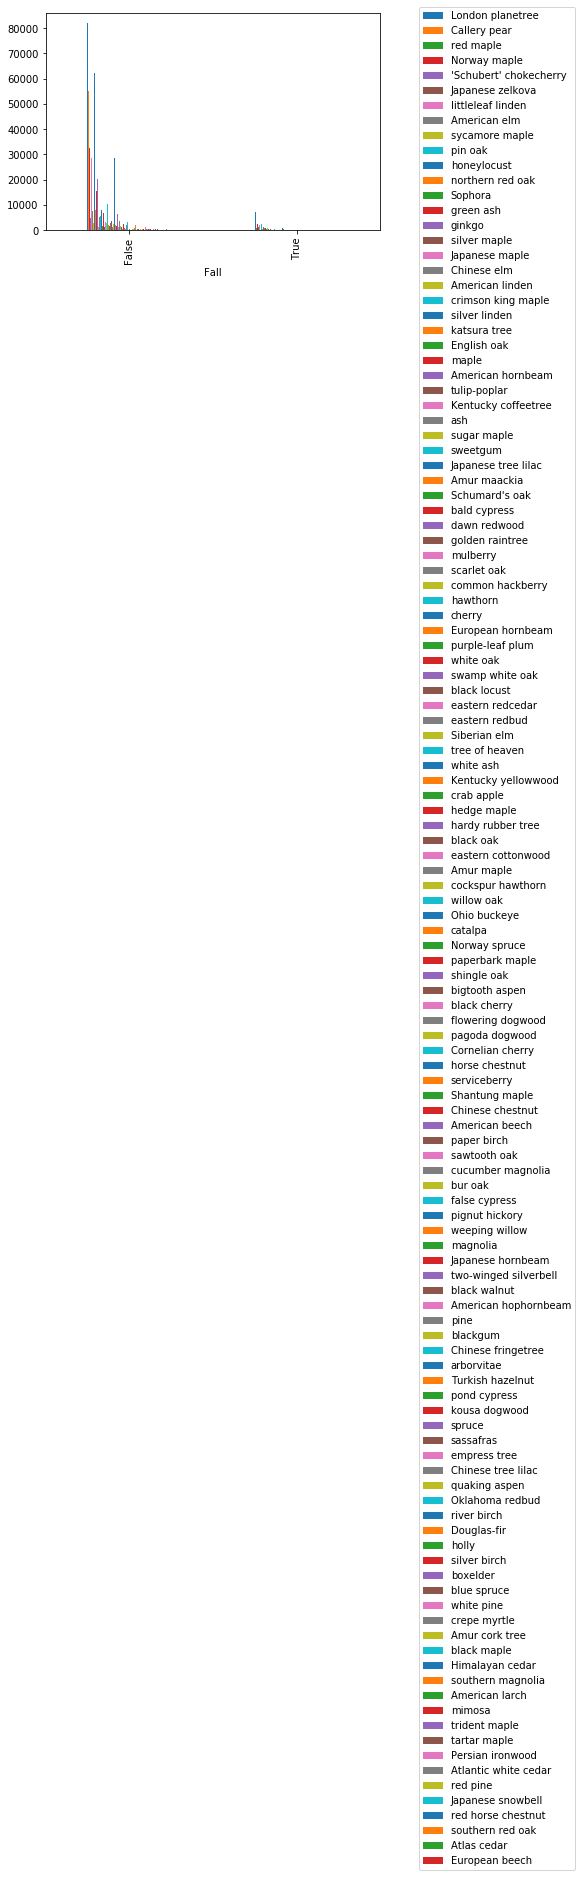

In [69]:
ax=dftemp.dropna(axis=1).plot.bar()
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

In [70]:
sp.stats.chi2_contingency(dftemp.dropna(axis=1))

(4916.814483859943,
 0.0,
 123,
 array([[8.38382581e+04, 5.75064000e+04, 1.64724624e+04, 3.29900780e+04,
         4.69217305e+03, 2.79329163e+04, 2.86290286e+04, 7.75600779e+03,
         2.60477690e+03, 5.06760334e+04, 6.11703964e+04, 8.00811331e+03,
         1.85786724e+04, 1.55392956e+04, 2.00480337e+04, 1.18019252e+04,
         1.06486365e+03, 5.10231489e+03, 1.29204084e+04, 5.61593287e+03,
         7.62713294e+03, 8.67318275e+02, 1.56343056e+03, 6.78709475e+03,
         1.44208125e+03, 1.02629527e+03, 3.19929442e+03, 2.48719037e+03,
         2.73177036e+03, 1.01745276e+04, 4.34599830e+03, 2.08551477e+03,
         1.41103841e+03, 1.18715365e+03, 2.88039974e+03, 3.54076571e+03,
         1.11095757e+03, 1.42514879e+03, 2.29622984e+03, 2.83524651e+03,
         2.77739393e+04, 1.99614900e+03, 6.63470260e+03, 1.59729548e+03,
         6.27159538e+03, 1.70171232e+03, 1.05169396e+03, 3.62448733e+03,
         1.52956563e+03, 7.22451665e+02, 1.07521127e+03, 4.57176444e+02,
         3.35356795

In [80]:
# Now check damage warnings
dftemp=pd.DataFrame()
dftemp['True']=data_with_falls_damage[data_with_falls_damage['Damage']==True].groupby('Fall').count().zipcode
dftemp['False']=data_with_falls_damage[data_with_falls_damage['Damage']==False].groupby('Fall').count().zipcode


In [81]:
dftemp.head()

,True,False
Fall,,
False,170507,582107
True,72973,21271


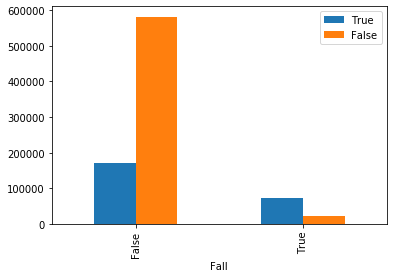

In [83]:
dftemp.plot.bar()